<a href="https://colab.research.google.com/github/ronen-halevy/shapes-dataset/blob/main/create_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create Shapes Dataset

This notebook demonstrates the creation of the shapes dataset

The notebook includes 3 chapters:
- Clone the `create-shape` repo 
  -The repo already holds a prepared dataset, as described in repo's `Readme.md`
- Create a new dataset based on `json` files
- Plot Dataset Examples - The code is almost a duplication of repo's `plot_images.py`

##Clone the repo

Repo already contains a shapes dataset created using current config files


In [27]:
!git clone https://github.com/ronen-halevy/shapes-dataset.git

Cloning into 'shapes-dataset'...
remote: Enumerating objects: 70180, done.
remote: Counting objects: 100% (28118/28118), done.
remote: Compressing objects: 100% (28010/28010), done.
remote: Total 70180 (delta 157), reused 28024 (delta 101), pack-reused 42062
Receiving objects: 100% (70180/70180), 358.56 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (612/612), done.


In [28]:
%cd shapes-dataset

/shapes-dataset


##Create a new dataset

Configurations are set in the 2 json files

In [29]:
config_file = 'config.json'
shapes_file = 'shapes.json'

!python create_shapes_dataset.py config_file shapes_file

## Plot Dataset Examples
Plot plot images+bounding boxes from dataset
This code is similar to contents of shapes-dataset/plot_image.py

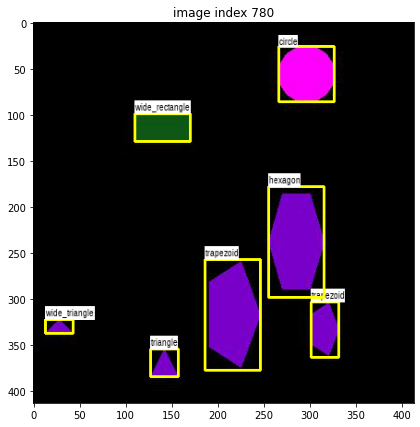

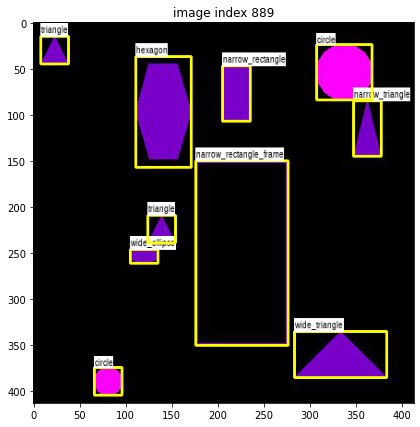

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import ImageFont
from PIL import Image, ImageDraw
import json


def draw_text_on_bounding_box(image, ymin, xmin, color, display_str_list=(), font_size=30):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", font_size)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    text_heights = [font.getsize(string)[1] for string in display_str_list]
    text_margin_factor = 0.05
    total_text_height = (1 + 2 * text_margin_factor) * sum(text_heights)

    if ymin > total_text_height:
        text_bottom = ymin
    else:
        text_bottom = ymin + total_text_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        text_margin = np.ceil(text_margin_factor * text_height)
        draw.rectangle([(xmin, text_bottom - text_height - 2 * text_margin),
                        (xmin + text_width, text_bottom)],
                       fill=color)
        draw.text((xmin + text_margin, text_bottom - text_height - text_margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * text_margin
        return image


def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, thickness=3):
    draw = ImageDraw.Draw(image)
    draw.line([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
               (xmin, ymin)],
              width=thickness,
              fill=color)
    return image


def plot_image_with_bbox(config, shapes, split, plot_setup):
    class_names = [shape['name'] for shape in shapes]

    annotations_path = config['splits'][split]["annotations_path"]
    font_size = config['annotations_font_size']
    text_color = tuple(config['annotatons_text_color'])

    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    figsize = plot_setup['figsize']
    num_of_images = plot_setup['num_of_images']
    start_index = plot_setup['start_index']
    random_select = plot_setup['random_select']

    for idx in range(num_of_images):
        image_index = np.random.randint(start_index, len(annotations)) if random_select else start_index + idx
        line = annotations[image_index]
        plt.figure(figsize=figsize)

        columns = [item.strip() for item in line.split(' ')]
        image = Image.open(columns[0])
        bboxes = columns[1:]
        for bbox in bboxes:
            class_id = list(map(int, bbox.split(',')))[4]
            bbox = list(map(int, bbox.split(',')))[:4]
            xmin, ymin, xmax, ymax = bbox
            image = draw_bounding_box(image, ymin, xmin, ymax, xmax, color='yellow', thickness=3)

            display_text = [class_names[class_id]] if class_names else [class_id]
            draw_text_on_bounding_box(image, ymin, xmin, text_color, display_str_list=display_text,
                                      font_size=font_size)

        plt.title(f'image index {image_index}')
        plt.imshow(image)
        plt.show()

plot_setup_params = {
  'num_of_images': 2,
  'start_index': 0,
  'random_select': True,
  'figsize': (7, 7)
}

with open('config.json') as f:
    config = json.load(f)

with open('shapes.json') as f:
    shapes = json.load(f)['shapes']

plot_image_with_bbox(config, shapes, split='validation', plot_setup=plot_setup_params)